# Project: Predicting Happiness of Songs
By Kristin Moser and Shayaan Saiyed


In this demo, we illustrate how to use Spotify API audio features data to determine the happiness of a song. The steps we took to do so:
* Process API data to retrieve audio features for around 1000 songs
* Perform multiple linear regression
* Use K-fold cross validation to choose the best model

We used Spotify's API as well as the Spotipy library:
* [Spotify API](https://developer.spotify.com/web-api/)
* [Spotipy](http://spotipy.readthedocs.io/en/latest/) 

We drew inspiration from several other projects that have been done.
> This [project](https://github.com/juandes/spotify-audio-features-data-experiment) used Spotify track's audio features (like us) to determine whether or not a user's music taste was boring. This was interesting, however, a self-defined feature set. The creator decided what values of the audio features qualified it as boring. In this [article](https://towardsdatascience.com/is-my-spotify-music-boring-an-analysis-involving-music-data-and-machine-learning-47550ae931de) they wrote about their process.

>This [project](https://devpost.com/software/partify-k94hpq) used Spotify track's audio features to reccommend songs to a ongoing party playlist. The user's favorited songs along with a selected mood fromt the user helps the app search for songs and creates a playlist from them. This application uses SVM to classify songs.

First, we load the data and parse it.

## Getting the data

Happiness in Spotify's audio features is called valence and can be a value 0-1. We will use other audio features of Spotify tracks in order to predict valence. These features include: danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, tempo. So essentially those features will be our Xs and valence will be our y.

In [287]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

To do craft the data we wanted we first grabbed Spotify's curated playlists till we had enough playlists whose track count was over 1100 gathered the playlist ids:

In [288]:
client_credentials_manager = SpotifyClientCredentials('6f613483241143f296a1e03996f8dae2', 'cd89960b4aaf4f07a749c8f93d3f61ed')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
playlists = sp.user_playlists('spotify')
playlist_data = [] # getting playlist ids
count = 0 # count how many songs are added --> stop around 1000 
while playlists:
    for i, playlist in enumerate(playlists['items']):
        if count < 1100:
            playlist_data.append(playlist['id']) #append ids here
            count += playlist['tracks']['total']
        else:
            break
    if playlists['next'] and count < 1100:
        playlists = sp.next(playlists)
    else:
        playlists = None

Next we went through all the playlist ids and made a request for the actual tracks from those playlists:

In [289]:
trackIDs = []
for playlistID in playlist_data: #go through all playlist ids and get the tracks from the playlists
    tracks = sp.user_playlist_tracks('spotify',playlistID)
    for i in tracks['items']:
        if 'track' in i and i['track'] != None:
            if 'id' in i['track']:
                ID = i['track']['id']
                trackIDs = trackIDs + [ID]

Then we got our column names:

In [290]:
audio_features = sp.audio_features(trackIDs[1])
feature_labels = list(audio_features[0].keys())[:11]
x = np.array(feature_labels)
print('features:', x)

features: ['danceability' 'energy' 'key' 'loudness' 'mode' 'speechiness'
 'acousticness' 'instrumentalness' 'liveness' 'valence' 'tempo']


Finally we added all the tracks audio information into a matrix:

In [291]:
for i in range(1, len(trackIDs), 50):
    audio_features = sp.audio_features(trackIDs[i: i+50])
    for tk in audio_features:
        if tk != None:
            features = np.array(list(tk.values())[:11])
            x = np.vstack((x, features))
print('There are ' + str(x.shape[0]) + ' tracks with ' + str(x.shape[1]) + ' audio features each track')

There are 994 tracks with 11 audio features each track


In [292]:
X = np.column_stack((x[1:,0:9], x[1:,10])).astype(np.float)
y = x[1:,9].astype(np.float)
print ('X\n', X, '\ny\n', y)

X
 [[  5.89000000e-01   7.31000000e-01   2.00000000e+00 ...,   0.00000000e+00
    3.08000000e-01   8.79080000e+01]
 [  6.48000000e-01   6.08000000e-01   8.00000000e+00 ...,   0.00000000e+00
    1.05000000e-01   1.26120000e+02]
 [  6.13000000e-01   8.42000000e-01   1.00000000e+01 ...,   0.00000000e+00
    2.30000000e-01   1.69917000e+02]
 ..., 
 [  5.53000000e-01   4.26000000e-01   1.10000000e+01 ...,   1.47000000e-05
    1.08000000e-01   1.06021000e+02]
 [  4.49000000e-01   1.25000000e-01   1.00000000e+01 ...,   1.08000000e-05
    1.07000000e-01   1.27699000e+02]
 [  2.30000000e-01   9.69000000e-02   0.00000000e+00 ...,   7.60000000e-01
    1.06000000e-01   1.34774000e+02]] 
y
 [ 0.191   0.488   0.645   0.216   0.264   0.434   0.154   0.33    0.333
  0.411   0.356   0.305   0.62    0.405   0.77    0.308   0.13    0.42
  0.819   0.244   0.607   0.182   0.656   0.349   0.579   0.183   0.779
  0.227   0.321   0.141   0.506   0.699   0.261   0.286   0.534   0.649
  0.574   0.332   0.238   

## Visualizing correlation

First, we wanted to see if these features were somehow correlated to happiness. 

Plotting loudness vs. valence.

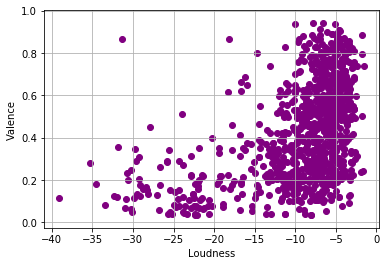

In [293]:
plt.scatter(X[:, 3], y, color='purple')
plt.xlabel('Loudness')
plt.ylabel('Valence')
plt.grid()
plt.show()

Plotting speechiness vs. valence

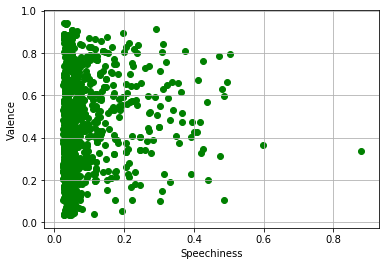

In [294]:
plt.scatter(X[:, 5], y, color='green')
plt.xlabel('Speechiness')
plt.ylabel('Valence')
plt.grid()
plt.show()

## Splitting the data into test and train

In [295]:
ns_train = 700
nsamples = X.shape[0]
ns_test = nsamples - ns_train
X_tr = X[:ns_train,:]     # Gets the first ns_train rows of X
y_tr = y[:ns_train]       # Gets the correspoinding rows of y
X_ts = X[ns_train:, :]
y_ts = y[ns_train:]
print("num samples train = %d, test = %d" % (ns_train, ns_test))

num samples train = 700, test = 293


## Fitting a linear model

In [296]:
import  sklearn.model_selection 
from sklearn import datasets, linear_model, preprocessing

In [297]:
regr = sklearn.linear_model.LinearRegression()
regr.fit(X_tr, y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [298]:
yts_hat = regr.predict(X_ts)
RSS = np.mean(((yts_hat-y_ts)**2)/(np.std(y_ts)**2))
print(RSS)
print(regr.score(X_ts, y_ts))

0.701795765696
0.298204234304


## Visualizing R^2 value for each audio feature

<Container object of 3 artists>

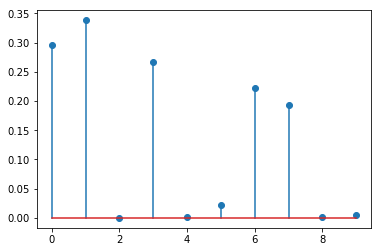

In [299]:
xm = np.mean(X_tr, axis=0)
ym = np.mean(y_tr)
X1 = X_tr-xm[None, :]
y1 = y_tr-ym
syy = np.mean(y1**2)
sxy = np.mean(X1*y1[:, None], axis=0)
sxx = np.mean(X1**2, axis=0)
Rsq = sxy**2/(1e-8+sxx)/syy
plt.stem(Rsq)

## K-Fold Cross Validation
We now want to determine which audio features should be used to predict valence. We accomplish this using K-Fold validation. Each model d represent the audio features with the d highest R^2 values. For example, d = 4 would fit the data to a linear regression using the 4 audio features with the highest R^2 values.

In [300]:
I = np.argsort(Rsq)[::-1]
print(I)

#create a kfold object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Model orders to be tested
print (X.shape[1])
dtest = np.arange(1,X.shape[1]+1) #test the highest d audio features
nd = len(dtest)

RSSts = np.zeros((nd,nfold)) #model orders x number of folds
for isplit, Ind in enumerate(kf.split(X)):
    
    print ("fold = %d " % isplit)
    
    #Get the training data in the split
    Itr, Its = Ind
    for it, d in enumerate(dtest):
        Isel = I[:d]
        X1 = X[:, Isel]
        X_tr = X1[Itr, :]
        X_ts = X1[Its, :]
        y_tr = y[Itr]
        y_ts = y[Its]
        regr.fit(X_tr, y_tr)
        yhat = regr.predict(X_ts)
        RSSts[it, isplit] = np.mean((yhat-y_ts)**2)


[1 0 3 6 7 5 9 8 4 2]
10
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 
fold = 5 
fold = 6 
fold = 7 
fold = 8 
fold = 9 


We then graph the RSS of the test data to see how it progresses with each model order. We can see that the RSS was the highest for the first model, which was to be expected.

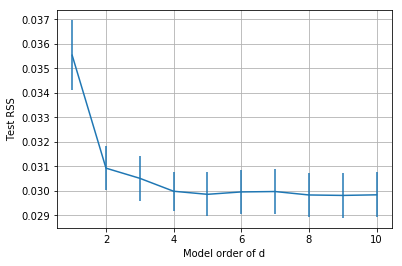

In [301]:
RSS_mean = np.mean(RSSts, axis=1)
RSS_std = np.std(RSSts, axis=1)/np.sqrt(nfold-1)

plt.errorbar(dtest, RSS_mean, yerr=RSS_std)
plt.grid()
plt.xlabel('Model order of d')
plt.ylabel('Test RSS')

## One Standard Error Rule
We then proceed to use the One Standard Error rule to predict the best model order.

The optimal d = 3
Test RSS per sample = 0.030517


(0.02, 0.05)

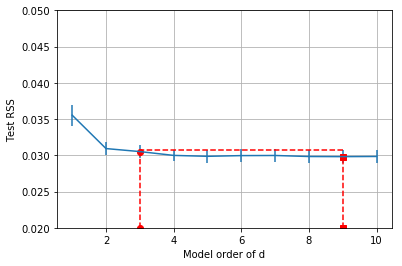

In [302]:
imin = np.argmin(RSS_mean)
dmin = dtest[imin]
RSS_tgt = RSS_mean[imin] + RSS_std[imin]
iopt = np.where(RSS_mean <= RSS_tgt)[0][0]
dopt = dtest[iopt]

print ("The optimal d = %d" % dopt)
print("Test RSS per sample = %f" % RSS_mean[iopt])

RSS_min_plt = 0.02
RSS_max_plt = 0.05
plt.errorbar(dtest, RSS_mean, yerr=RSS_std)
plt.plot([dmin, dmin], [RSS_min_plt, RSS_mean[imin]], 'rs--')
plt.plot([dmin, dopt], [RSS_tgt, RSS_tgt], 'r--')
plt.plot([dopt, dopt], [RSS_min_plt, RSS_mean[iopt]], 'ro--')
plt.grid()
plt.xlabel('Model order of d')
plt.ylabel('Test RSS')
plt.ylim([RSS_min_plt, RSS_max_plt])

According to the one standard error rule, the best model to use was 2, which means that the best way to predict the valence of a track is to use the "danceability" and the "energy"